In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
import netCDF4 as nc
import cartopy.crs as ccrs

In [3]:
filename = '/Users/g/Documents/CMIP5/tas_Amon_CCSM4_historical_r1i1p1_185001-200512.nc'

In [4]:
ds = nc.Dataset(filename)

In [9]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    institution: NCAR (National Center for Atmospheric Research) Boulder, CO, USA
    institute_id: NCAR
    experiment_id: historical
    source: CCSM4
    model_id: CCSM4
    forcing: Sl GHG Vl SS Ds SD BC MD OC Oz AA LU
    parent_experiment_id: piControl
    parent_experiment_rip: r1i1p1
    branch_time: 937.0
    contact: cesm_data@ucar.edu
    references: Gent P. R., et.al. 2011: The Community Climate System Model version 4. J. Climate, doi: 10.1175/2011JCLI4083.1
    initialization_method: 1
    physics_version: 1
    tracking_id: 84f8ed43-1304-45b4-898d-ff5bfd94e04e
    acknowledgements: The CESM project is supported by the National Science Foundation and the Office of Science (BER) of the U.S. Department of Energy. NCAR is sponsored by the National Science Foundation. Computing resources were provided by the Climate Simulation Laboratory at the NCAR Computational and Information Sy

In [7]:
ds.variables.keys()

odict_keys(['time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'height', 'tas'])

In [8]:
ds.variables['tas']

<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    original_name: TREFHT
    comment: TREFHT no change
    cell_methods: time: mean (interval: 30 days)
    cell_measures: area: areacella
    history: 2011-10-21T17:19:24Z altered by CMOR: Treated scalar dimension: 'height'. 2011-10-21T17:19:24Z altered by CMOR: replaced missing value flag (-1e+32) with standard missing value (1e+20).
    coordinates: height
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_CCSM4_historical_r0i0p0.nc areacella: areacella_fx_CCSM4_historical_r0i0p0.nc
unlimited dimensions: time
current shape = (1872, 192, 288)
filling on

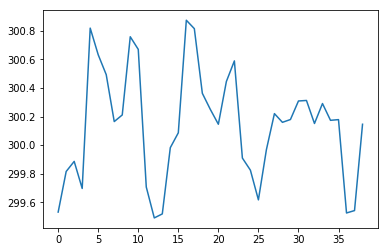

In [17]:
plt.plot(ds['tas'][1:40,100,100])

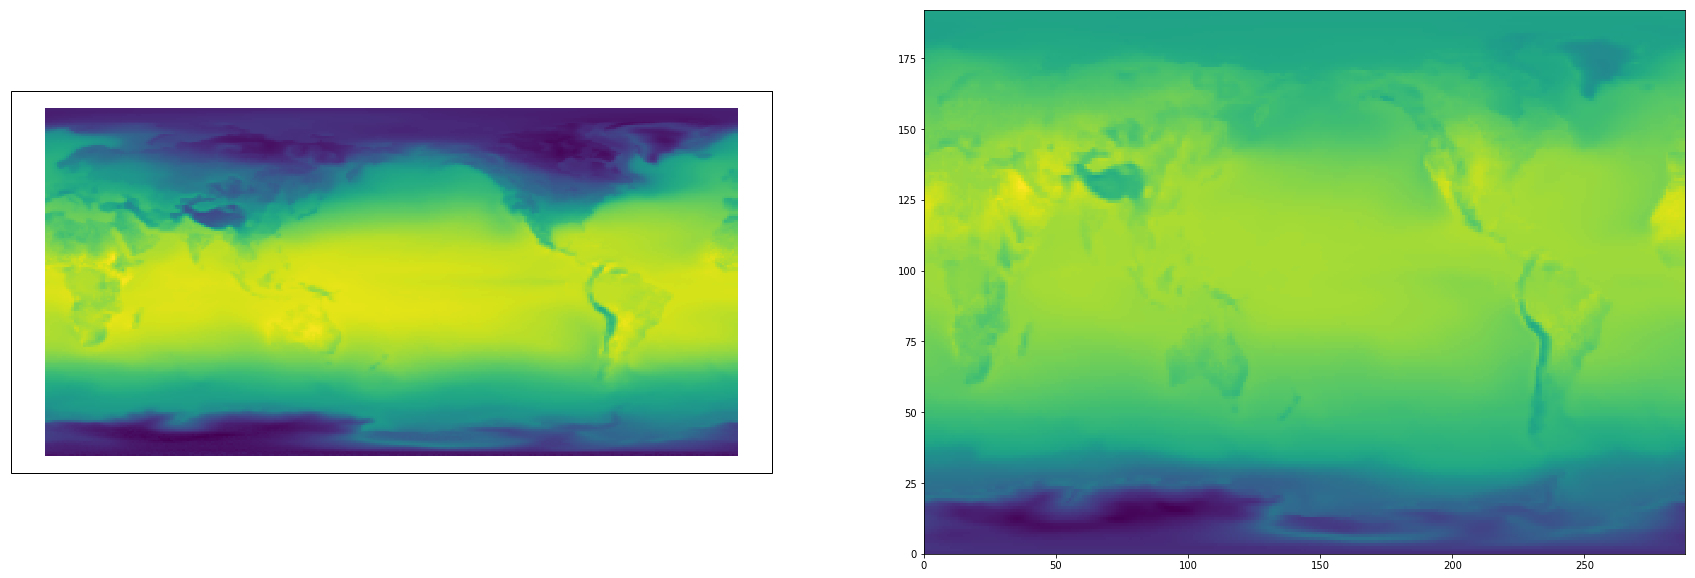

In [31]:
fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(121, projection= ccrs.NearsidePerspective())
ax1.pcolormesh(ds['lon'], ds['lat'], ds['tas'][1,:,:], transform= ccrs.NearsidePerspective())

ax2 = fig.add_subplot(122)
ax2.pcolormesh(ds['tas'][7,:,:])


In [36]:
simple_mean = np.mean(ds['tas'][1,:,:])
simple_mean

274.66898148148147